In [1]:
import pandas as pd

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 

from sklearn.metrics import f1_score, make_scorer
import numpy as np

# отключение предупреждений
import warnings; warnings.filterwarnings("ignore", category=Warning)

In [3]:
from collections import Counter
import re
import pymorphy2

In [4]:
import nltk
#nltk.download('stopwords')

In [5]:
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from catboost import CatBoostClassifie

# грузим сет

In [ ]:
# исходный сет 
# train = pd.read_parquet('data_fusion_train.parquet')

# удаляем лишнее

In [ ]:
#train = train.drop(['receipt_id', 'receipt_dayofweek', 'receipt_time','brands'], axis='columns')

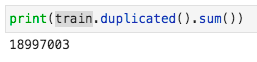

из 26 млн - 18.9 полные дубликаты по item_quantity - item_price - item_nds_rate - category_id

In [ ]:
# train_no_dublic= train.drop_duplicates().reset_index(drop=True)

In [ ]:
# train_no_dublic.to_parquet('data_fusion_train_no_dubl')

In [ ]:
# train_no_dublic.item_name = train_no_dublic.item_name.str.lower()

In [ ]:
# print(train_no_dublic.duplicated().sum())
# было порядка 34 тыс после перевода в нижний

In [ ]:
# train_no_dublic_low= train_no_dublic.drop_duplicates().reset_index(drop=True)

In [ ]:
# train_no_dublic_low.to_parquet('data_fusion_train_no_dubl_low')

## грузим сет - без дубликатов и в нижнем регистре

In [ ]:
# сет для анализа 
#train = pd.read_parquet('data_fusion_train_no_dubl_low')

## удаляем символы ненужные

In [ ]:
# удаляем ненужные знаки

# remove = [",", ".", "*", '"', "№", ")", "(", "%", '/', '+','-','#',':',';','@','$','^','&','=']
# train['item_name_clean'] = train['item_name'].str.replace(r"[{}]+".format(" ".join([re.escape(x) for x in remove]))," ", regex=True)

In [ ]:
# удаляем цифры

# train['item_name_clean'] = train['item_name_clean'].apply(
#     lambda x:''.join(ch for ch in x if ch.isalpha() or ch.isspace())
# )

In [ ]:
# проверяем наличие дубликатов

#print(train.duplicated().sum())
# нет дубликатов

In [ ]:
# сохраняем сет без цифр и знаков препинаний и спец знаков

#train.to_parquet('data_fusion_train_no_dubl_low_wo_simb')

## tokenizing

In [ ]:
# train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb')

In [ ]:
# %%time
# train['item_name_token'] = train.apply(lambda x: nltk.word_tokenize(x['item_name_clean']), axis=1)

In [ ]:
#train.to_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

In [ ]:
#train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

## отбор слов фикс длины - новый столбец 

In [ ]:
def words(text, min_len):
    text = [w for w in text if len(w) >= min_len]
        
    return ' '.join(text)

# класс 71

## формируем словарь

In [ ]:
# class_71 = train.query('category_id == 71')

In [ ]:
# сохняем сет для класса 71

# class_71.to_parquet('train_71')

In [ ]:
#class_71 = pd.read_parquet('train_71')

In [ ]:
# выбираем слова заданной длины - через функцию words
#class_71['items'] = class_71['item_name_token'].apply(func=lambda x : words(x, 4))

In [ ]:
# заполняем пробелы между словами на "_"
# наверное это уже можно и не делать - так как используется строгое обращение - .isin()
# remove = [" "]
# class_71['items_'] = class_71['items'].str.replace(r"[{}]+".format("".join([re.escape(x) for x in remove])),"_", regex=True)

In [ ]:
# получаем словарь для cat 71 состоящий из слов >= 4 буквы
# common = pd.Series(class_71['items_'].value_counts().sort_values(ascending = False)).reset_index().query('index != ""')
# print(len(common))

In [ ]:
# убираем слова встречающиеся лишь 1 раз (возможно это неправильно), цель сокращения словаря - сократить время фильтрации неразмеченного train
# common = common.query('items_ > 1')
# common

In [ ]:
             # проверка  - не удалять
#common.loc[common.loc[:, 'index'] == 'картофель']

In [ ]:
# сохраняем словарь для класса 71
# common.to_parquet('dict_71')

In [ ]:
# dict_71 = pd.read_parquet('dict_71')

In [ ]:
#class_71 = pd.read_parquet('train_71')

In [ ]:
            # НЕ УДАЛЯТЬ
# работающий пример - поиск по слову
# dict_temp = ['салат_сельдь_под_шубой']
# WWW = class_71[class_71['items_'].str.contains('|'.join(dict_temp))]
# WWW

In [ ]:
# из DataFrame в список
# dict_71 = (dict_71['index'].to_list())

**словарь для класса 71 - готов**

## подготовка неразмеченной выборки

**подготовим генеральныю выборку - применим ограничение по длине слова**
изначально использовал длинные слова - 5+, но после использования _ решил сократить ограничение до 4-х, так как теряются важные детали

In [ ]:
# грузим трейн основной
# train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

In [ ]:
%%time

# разбиваем токенизированный набор на отдельные слова
train['item_name_4_letters'] = train['item_name_token'].apply(func=lambda x : words(x, 4))

In [ ]:
%%time
# заполняем пробелы между словами на "_"
remove = [" "]
train['items_'] = train['item_name_4_letters'].str.replace(r"[{}]+".format("".join([re.escape(x) for x in remove])),"_", regex=True)

In [ ]:
%%time
# так как разметка делается по **item_name** и **items_** убираем ненужные столбцы
train_short = train.drop(['item_quantity', 'item_price', 'item_nds_rate', 'item_name_clean', 'item_name_token', 'item_name_4_letters'], axis='columns')

In [ ]:
# сохраняем неразмеченную обрезанную выборку
train_short.to_parquet('train_short')

## выбираем признаки относящиеся к классу № 71

In [ ]:
train_short = pd.read_parquet('train_short')

In [ ]:
%%time
train_short['cat_71'] = train_short['items_'].isin(dict_71)

In [ ]:
train_short["cat_71"] = train_short["cat_71"].astype(int)

In [ ]:
train_short.loc[train_short['cat_71'] == 1, 'cat_71'] = 71

In [ ]:
train_short.loc[20:24, :]

In [ ]:
train_origin_cat_71 = train_short.query('cat_71 == 71 or category_id !=-1')
train_origin_cat_71.info()

In [ ]:
train_origin = train_short.query('category_id !=-1')
train_origin.info()

In [ ]:
train_origin

In [ ]:
# засунем cat_71 в category_id
# меняем только в тех признаках, где есть -1
train_origin_cat_71.loc[train_origin_cat_71['category_id'] == -1, 'category_id'] = 71
train_origin_cat_71

In [ ]:
# сохраняем только неразмеченную обрезанную выборку все !=-1
train_origin.to_parquet('train_origin')

In [ ]:
# сохраняем неразмеченную обрезанную выборку все !=-1 и + к этому доп размеченную категорию 71
train_origin_cat_71.to_parquet('train_origin_cat_71')

# ВЕКТОРИЗАЦИЯ --- TfidfVectorizer

In [7]:
stop = stopwords.words('russian')

In [33]:
train_origin = pd.read_parquet('train_origin')

In [35]:
train_origin = train_origin.drop(['items_', 'cat_71'], axis='columns')

In [38]:
train_origin_cat_71 = pd.read_parquet('train_origin_cat_71')

In [39]:
train_origin_cat_71 = train_origin_cat_71.drop(['items_', 'cat_71'], axis='columns')

In [44]:
print(train_origin.duplicated().sum())

0


In [43]:
train_origin= train_origin.drop_duplicates()

In [46]:
print(train_origin_cat_71.duplicated().sum())

0


In [45]:
train_origin_cat_71= train_origin_cat_71.drop_duplicates()

### train_short_origin

In [47]:
tfidf_orig = TfidfVectorizer(stop_words=stop, max_features=100000)
X_train_orig = tfidf_orig.fit_transform(train_origin.item_name)
y_train_orig = train_origin['category_id']

In [48]:
print(X_train_orig.shape)

(48018, 37160)


### train_short + cat_71

In [49]:
tfidf_ext = TfidfVectorizer(stop_words=stop, max_features=100000)
X_train_ext = tfidf_ext.fit_transform(train_origin_cat_71.item_name)
y_train_ext = train_origin_cat_71['category_id']

In [50]:
print(X_train_ext.shape)

(91374, 38832)


# РЕЗУЛЬТАТЫ

# LinearSVC

**1_1 расчет baseline - исходный сет**

In [51]:
%%time
clf_1_1 = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
scores_1_1 = cross_val_score(clf_1_1, X_train_orig, y_train_orig, cv=8, scoring='f1_weighted')

CPU times: user 2min 13s, sys: 580 ms, total: 2min 13s
Wall time: 2min 14s


In [52]:
np.mean(scores_1_1)

0.8097410199635287

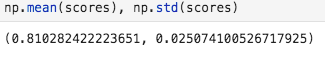

**1_2 расчет baseline + новая выборка для cat_71**

In [53]:
%%time
clf_1_2 = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
scores_1_2 = cross_val_score(clf_1_2, X_train_ext, y_train_ext, cv=8, scoring='f1_weighted')

CPU times: user 4min 37s, sys: 950 ms, total: 4min 38s
Wall time: 4min 38s


In [54]:
np.mean(scores_1_2)

0.8793356263271906

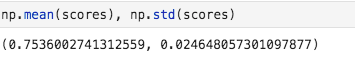

In [55]:
clf_1_2.fit(X_train_ext, y_train_ext)

LinearSVC(class_weight='balanced', max_iter=400, random_state=12345)

## подготовка данных для загрузки на сайт

In [56]:
tfidf = tfidf_ext
clf = clf_1_2

In [57]:
import pickle

pickle.dump(tfidf, open('t1_sub/tfidf', 'wb'))
pickle.dump(clf, open('t1_sub/clf_task1', 'wb'))

In [58]:
!ls -lh t1_sub

total 63648
-rw-r--r--@ 1 romanfomin  staff    29M Feb 15 11:34 clf_task1
-rw-r--r--@ 1 romanfomin  staff   372B Jan 24 11:54 script.py
-rw-r--r--@ 1 romanfomin  staff   1.2M Feb 15 11:34 tfidf


In [59]:
import zipfile 
compression = zipfile.ZIP_DEFLATED

debutants = 't1_sub/submission.zip'

with zipfile.ZipFile(debutants, 'w') as zipObj:
    for filename in ['clf_task1', 'tfidf', 'script.py']:
        zipObj.write(
            f't1_sub/{filename}', 
            arcname=filename, 
            compress_type=compression
        )
    print(zipObj.namelist())



['clf_task1', 'tfidf', 'script.py']


In [60]:
!ls -lh {debutants}

-rw-r--r--  1 romanfomin  staff   6.7M Feb 15 11:34 t1_sub/submission.zip
